In [69]:
import numpy as np
import matplotlib.pyplot as plt

ms = 1e-3
mV = 1e-3
mA = 1e-3
nA = 1e-9
pA = 1e-12
nS = 1e-9
pF = 1e-12
# whole world time
tick_time = 0
# minium gap time3
dt = 0.1 * ms
# total time
# TotTime = 4000 * ms
TotTime = 400 * ms
# time of fire
fire1_num = 0
fire2_num = 0
time_sim = np.arange(0, TotTime, dt)
# average data analysis
bin_num = 100
def bin_data(data):
    try:
        return np.mean(data[len(data) - bin_num:len(data)])
    finally:
        return data[len(data) - 1]


In [68]:
class AdExNeuron:
    def __init__(self, name, V_Neuron, w_adaptive, G_Synapsis_Excitatory, G_Synapsis_Inhibitory,
                 E_Excitatory, E_Inhibitory, E_local, G_local, V_disturb, V_Excitatory_Threshold, C_Membrane,
                 a_w_adaptive, tau_w_adaptive,
                 tau_Synapsis,
                 V_Reset_Threshold, V_Reset, b_w_adaptive,
                 I_Synapsis, T_refractory, T_rest,
                 Connecting_Neuron, Q_Synapsis, Probability_Connecting):
        # variable parameters
        self.name = name
        self.V_Neuron = V_Neuron
        self.w_adaptive = w_adaptive
        self.G_Synapsis_Excitatory = G_Synapsis_Excitatory
        self.G_Synapsis_Inhibitory = G_Synapsis_Inhibitory
        # fixed parameters
        self.E_Excitatory = E_Excitatory
        self.E_Inhibitory = E_Inhibitory
        self.E_local = E_local
        self.G_local = G_local
        self.V_disturb = V_disturb
        self.V_Excitatory_Threshold = V_Excitatory_Threshold
        self.C_Membrane = C_Membrane
        self.T_refractory = T_refractory
        # adaptive parameters
        self.a_w_adaptive = a_w_adaptive
        self.tau_w_adaptive = tau_w_adaptive
        self.tau_Synapsis = tau_Synapsis
        # reset parameters
        self.V_Reset_Threshold = V_Reset_Threshold
        self.V_Reset = V_Reset
        self.b_w_adaptive = b_w_adaptive
        self.I_Synapsis = I_Synapsis
        self.T_rest = T_rest
        # connecting neurons
        self.Connecting_Neuron = Connecting_Neuron
        self.Q_Synapsis = Q_Synapsis
        self.Probability_Connecting = Probability_Connecting

    def refresh_membrane_potential(self):
        if self.T_rest <= 0:
            self.V_Neuron = self.V_Neuron + dt * (self.G_Synapsis_Excitatory * (self.E_Excitatory - self.V_Neuron) +
                                                  self.G_Synapsis_Inhibitory * (self.E_Inhibitory - self.V_Neuron) +
                                                  self.G_local * (self.E_local - self.V_Neuron) +
                                                  self.G_local * self.V_disturb * np.exp(
                        (self.V_Neuron - self.V_Excitatory_Threshold) / self.V_disturb) -
                                                  self.w_adaptive + self.I_Synapsis
                                                  ) / self.C_Membrane
        else:
            self.T_rest = self.T_rest - dt

    def refresh_w_adaptive(self):
        if self.T_rest <= 0:
            self.w_adaptive = self.w_adaptive + dt * (
                    self.a_w_adaptive * (self.V_Neuron - self.E_local) - self.w_adaptive) / self.tau_w_adaptive

    def refresh_G_Synapsis_Excitatory(self):
        if self.T_rest <= 0:
            self.G_Synapsis_Excitatory = self.G_Synapsis_Excitatory - dt * self.G_Synapsis_Excitatory / self.tau_Synapsis

    def refresh_G_Synapsis_Inhibitory(self):
        if self.T_rest <= 0:
            self.G_Synapsis_Inhibitory = self.G_Synapsis_Inhibitory - dt * self.G_Synapsis_Inhibitory / self.tau_Synapsis

    def fire(self, num1, num2):
        # refresh self parameter
        self.V_Neuron = self.V_Reset
        self.w_adaptive = self.w_adaptive + self.b_w_adaptive
        self.T_rest = self.T_refractory
        # refresh the G_Synapsis
        if self.name[1] == '1':
            num1 = num1 + 1
            for neuron1 in self.Connecting_Neuron:
                neuron1.G_Synapsis_Inhibitory = neuron1.G_Synapsis_Inhibitory + self.Q_Synapsis
        if self.name[1] == '2':
            num2 = num2 + 1
            for neuron2 in self.Connecting_Neuron:
                neuron2.G_Synapsis_Excitatory = neuron2.G_Synapsis_Excitatory + self.Q_Synapsis
        return num1, num2

    def judge_fire(self, num1, num2):
        if self.V_Neuron > self.V_Reset_Threshold:
            num1, num2 = self.fire(num1, num2)
        else:
            pass
        return num1, num2

    def Add_Synapsis(self, Synapsis):
        self.Connecting_Neuron.append(Synapsis)


In [63]:
Fast_Spiking_neuron = AdExNeuron(name="G1_1", V_Neuron=-65 * mV, w_adaptive=0.0 * pA, G_Synapsis_Excitatory=0.0 * nS,
                                 G_Synapsis_Inhibitory=0.0 * nS,
                                 E_Excitatory=0.0 * mV, E_Inhibitory=-80 * mV, E_local=-65 * mV, G_local=10 * nS,
                                 V_disturb=0.5 * mV, V_Excitatory_Threshold=-48 * mV, C_Membrane=200 * pF,
                                 a_w_adaptive=0.0 * nS, tau_w_adaptive=1.0 * ms,
                                 tau_Synapsis=5.0 * ms,
                                 V_Reset_Threshold=-47.5 * mV, V_Reset=-65 * mV, b_w_adaptive=0.0 * pA,
                                 I_Synapsis=0.0 * pA, T_refractory=5 * ms, T_rest=0 * ms,
                                 Connecting_Neuron=[], Q_Synapsis=5.0 * nS, Probability_Connecting=0.05)
Regular_Spiking_neuron = AdExNeuron(name="G2_1", V_Neuron=-65 * mV, w_adaptive=0.0 * pA, G_Synapsis_Excitatory=0.0 * nS,
                                    G_Synapsis_Inhibitory=0.0 * nS,
                                    E_Excitatory=0.0 * mV, E_Inhibitory=-80 * mV, E_local=-65 * mV, G_local=10 * nS,
                                    V_disturb=2 * mV, V_Excitatory_Threshold=-50 * mV, C_Membrane=200 * pF,
                                    a_w_adaptive=0.0 * nS, tau_w_adaptive=1000.0 * ms,
                                    tau_Synapsis=5.0 * ms,
                                    V_Reset_Threshold=-47.5 * mV, V_Reset=-65 * mV, b_w_adaptive=0.0 * pA,
                                    I_Synapsis=0.0 * pA, T_refractory=5 * ms, T_rest=0 * ms,
                                    Connecting_Neuron=[], Q_Synapsis=1.5 * nS, Probability_Connecting=0.05)


In [64]:
N1 = 1
N2 = 4
N_in = 4
# create neurons
G1_Group = []
G2_Group = []
G_Group = []
P2_Group = []

for i in range(1, N1 + 1):
    globals()['G1_' + str(i)] = AdExNeuron(name="G1_" + str(i), V_Neuron=-65 * mV, w_adaptive=0.0 * pA,
                                           G_Synapsis_Excitatory=0.0 * nS, G_Synapsis_Inhibitory=0.0 * nS,
                                           E_Excitatory=0.0 * mV, E_Inhibitory=-80 * mV, E_local=-65 * mV,
                                           G_local=10 * nS, V_disturb=0.5 * mV, V_Excitatory_Threshold=-48 * mV,
                                           C_Membrane=200 * pF,
                                           a_w_adaptive=0.0 * nS, tau_w_adaptive=1.0 * ms,
                                           tau_Synapsis=5.0 * ms,
                                           V_Reset_Threshold=-47.5 * mV, V_Reset=-65 * mV, b_w_adaptive=0.0 * pA,
                                           I_Synapsis=0.0 * pA, T_refractory=5 * ms, T_rest=0 * ms,
                                           Connecting_Neuron=[], Q_Synapsis=5.0 * nS, Probability_Connecting=0.05)
    G1_Group.append(globals()['G1_' + str(i)])

for i in range(1, N2 + 1):
    globals()['G2_' + str(i)] = AdExNeuron(name="G2_" + str(i), V_Neuron=-65 * mV, w_adaptive=0.0 * pA,
                                           G_Synapsis_Excitatory=0.0 * nS, G_Synapsis_Inhibitory=0.0 * nS,
                                           E_Excitatory=0.0 * mV, E_Inhibitory=-80 * mV, E_local=-65 * mV,
                                           G_local=10 * nS, V_disturb=2 * mV, V_Excitatory_Threshold=-50 * mV,
                                           C_Membrane=200 * pF,
                                           a_w_adaptive=0.0 * nS, tau_w_adaptive=1000.0 * ms,
                                           tau_Synapsis=5.0 * ms,
                                           V_Reset_Threshold=-47.5 * mV, V_Reset=-65 * mV, b_w_adaptive=0.0 * pA,
                                           I_Synapsis=0.0 * pA, T_refractory=5 * ms, T_rest=0 * ms,
                                           Connecting_Neuron=[], Q_Synapsis=1.5 * nS, Probability_Connecting=0.05)
    G2_Group.append(globals()['G2_' + str(i)])

for i in range(1, N_in + 1):
    globals()['P2_' + str(i)] = AdExNeuron(name="P2_" + str(i), V_Neuron=-65 * mV, w_adaptive=0.0 * pA,
                                           G_Synapsis_Excitatory=0.0 * nS, G_Synapsis_Inhibitory=0.0 * nS,
                                           E_Excitatory=0.0 * mV, E_Inhibitory=-80 * mV, E_local=-65 * mV,
                                           G_local=10 * nS, V_disturb=2 * mV, V_Excitatory_Threshold=-50 * mV,
                                           C_Membrane=200 * pF,
                                           a_w_adaptive=0.0 * nS, tau_w_adaptive=1000.0 * ms,
                                           tau_Synapsis=5.0 * ms,
                                           V_Reset_Threshold=-47.5 * mV, V_Reset=-65 * mV, b_w_adaptive=0.0 * pA,
                                           I_Synapsis=0.0 * pA, T_refractory=5 * ms, T_rest=0 * ms,
                                           Connecting_Neuron=[], Q_Synapsis=1.5 * nS, Probability_Connecting=0.05)
    P2_Group.append(globals()['P2_' + str(i)])

G_Group = G1_Group + G2_Group


In [65]:
for neuron_front in G_Group:
    for neuron_back in G_Group:
        if neuron_front != neuron_back:
            # if np.random.rand()<neuron_front.Probability_Connecting:
            neuron_front.Connecting_Neuron.append(neuron_back)

for neuron_front in P2_Group:
    for neuron_back in G_Group:
        if neuron_front != neuron_back:
            # if np.random.rand()<neuron_front.Probability_Connecting:
            neuron_front.Connecting_Neuron.append(neuron_back)


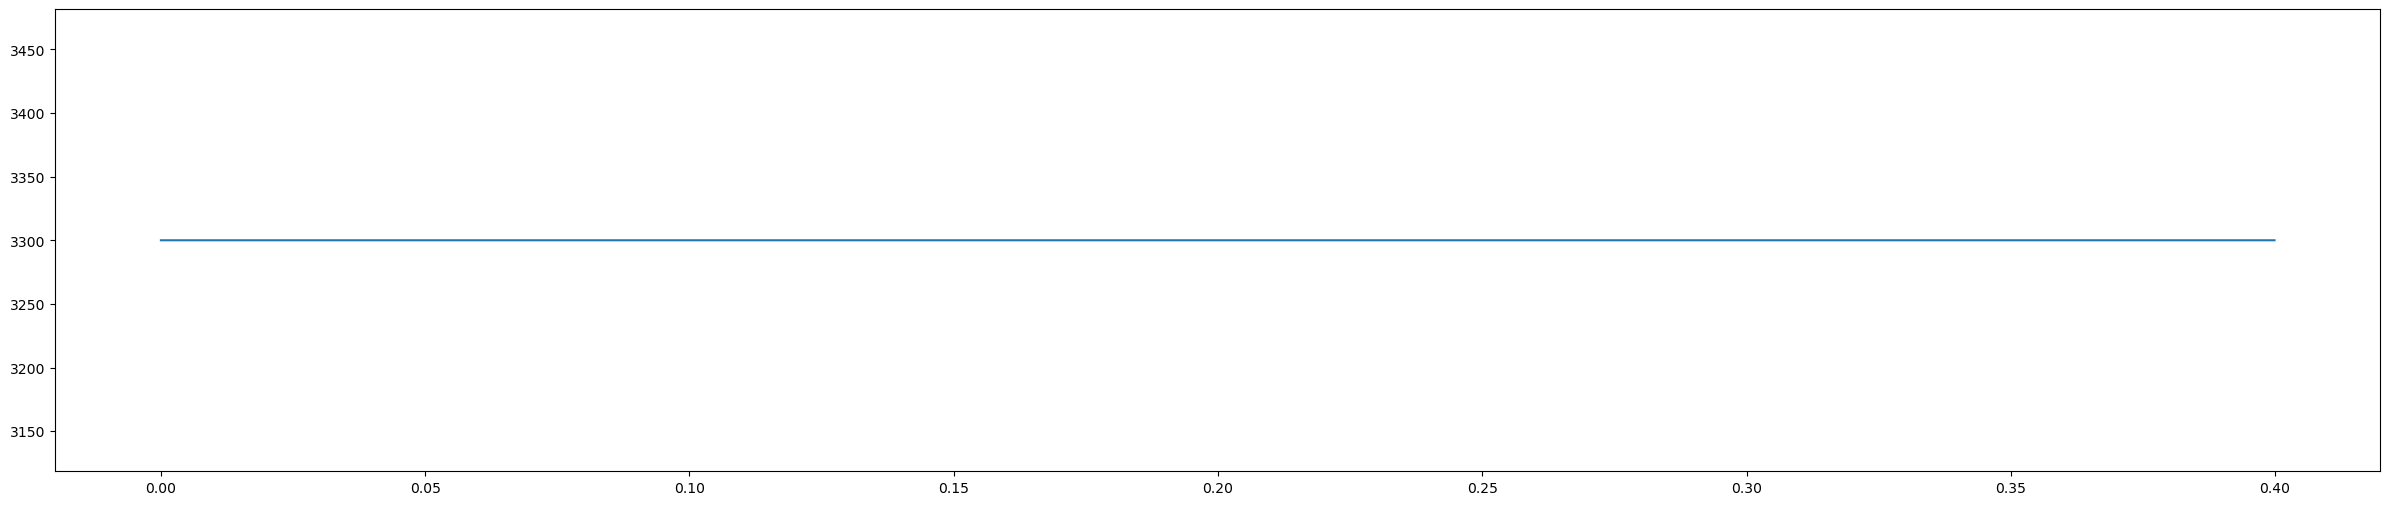

In [66]:

AmpStim = 3385.3  # 80. #92.
plat = 1000
def heaviside(x):
    return 0.5 * (1 + np.sign(x))
def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc, plateau):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) +
                      heaviside(-(t - (t1_exc + plateau))) * heaviside(t - t1_exc) +
                      np.exp(-(t - (t1_exc + plateau)) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - (t1_exc + plateau)))
    return inp
# 创建仿真时间序列
t2 = np.arange(0, 1000 * TotTime, 1000 * dt)
test_input = []
# 输入的噪声强度
TauP = 100
rest = 3300
# 将时间点，噪声，输入刺激，输入刺激的平台期产生对应时间的脉冲
for ji in t2:
    test_input.append(rest + input_rate(ji, 2000., TauP, TauP, AmpStim - rest, plat))

plt.figure(figsize=(30, 6))
plt.plot(time_sim, test_input)

1
fire_probability:0.33


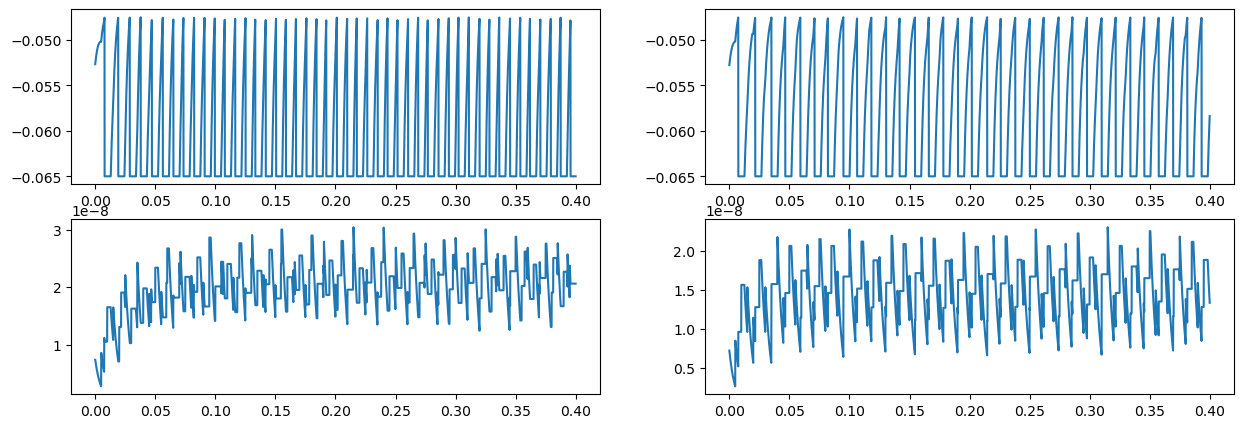

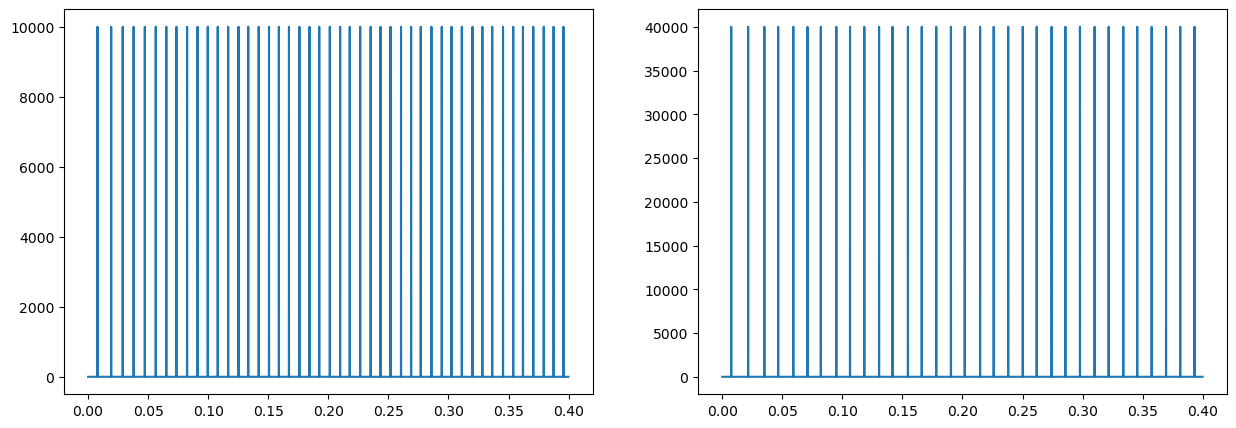

In [ ]:
fire1_result = []
fire2_result = []
fire1_result_bin = []
fire2_result_bin = []
neuron1_potential_bin = []
neuron2_potential_bin = []
neuron1_w_adaptive_bin = []
neuron2_w_adaptive_bin = []
test_input_index = 0
for tick_time in np.arange(0, TotTime, dt):
    fire_probability = dt * test_input[test_input_index]
    test_input_index = test_input_index + 1
    if test_input_index % 5000 == 1:
        print(test_input_index)
        print("fire_probability:" + str(fire_probability))
    for neuron in P2_Group:
        # if np.random.rand()<1:
        if test_input_index % 50 == 1:
            #     print("fire")
            neuron.fire(0, 0)
    fire1_num = 0
    fire2_num = 0
    fire1_frequent = 0
    fire2_frequent = 0
    for neuron in G_Group:
        neuron.refresh_membrane_potential()
        neuron.refresh_w_adaptive()
        neuron.refresh_G_Synapsis_Excitatory()
        neuron.refresh_G_Synapsis_Inhibitory()
        fire1_num, fire2_num = neuron.judge_fire(fire1_num, fire2_num)
    neuron1_potential_bin.append(G1_1.V_Neuron)
    neuron1_w_adaptive_bin.append(G1_1.G_Synapsis_Excitatory)
    neuron2_potential_bin.append(G2_1.V_Neuron)
    neuron2_w_adaptive_bin.append(G2_1.G_Synapsis_Excitatory)
    fire1_frequent = fire1_num / dt
    fire2_frequent = fire2_num / dt
    fire1_result.append(fire1_frequent)
    fire2_result.append(fire2_frequent)
    fire1_result_bin.append(bin_data(fire1_result))
    fire2_result_bin.append(bin_data(fire2_result))

fig1 = plt.figure(figsize=(15, 5))
ax1 = fig1.add_subplot(221)
ax2 = fig1.add_subplot(222)
ax3 = fig1.add_subplot(223)
ax4 = fig1.add_subplot(224)
ax1.plot(time_sim, neuron1_potential_bin)
ax2.plot(time_sim, neuron2_potential_bin)
ax3.plot(time_sim, neuron1_w_adaptive_bin)
ax4.plot(time_sim, neuron2_w_adaptive_bin)
plt.show()

fig2 = plt.figure(figsize=(15, 5))
bx1 = fig2.add_subplot(121)
bx2 = fig2.add_subplot(122)

bx1.plot(time_sim, fire1_result_bin)
bx2.plot(time_sim, fire2_result_bin)
plt.show()
